In [89]:
import mne
from mne.io import concatenate_raws, read_raw_edf
import matplotlib.pyplot as plt
import mne.viz
import os
import os.path as op
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.datasets import fetch_fsaverage

import torch
from torcheeg.models import EEGNet
from torcheeg.models import DGCNN
from torcheeg import transforms

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy as sc
from matplotlib import cm
import matplotlib.colors as colors

In [90]:
import sys 
sys.path.append("/home/aurelien.stumpf/Code")
from eeg_project_package import dataset, models, training

In [107]:
import importlib
importlib.reload(dataset)
importlib.reload(training)

<module 'eeg_project_package.training' from '/home/aurelien.stumpf/Code/eeg_project_package/training.py'>

Number of channels:  64
Number of samples:  64


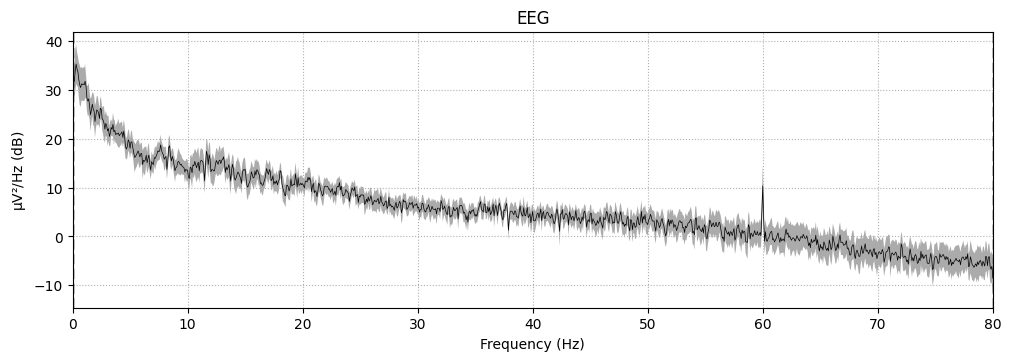

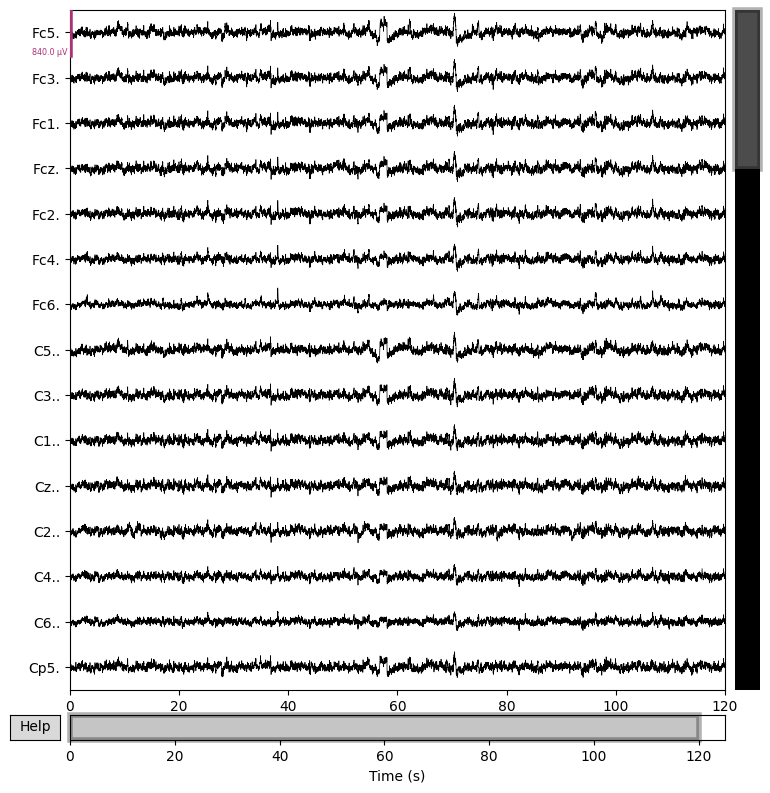

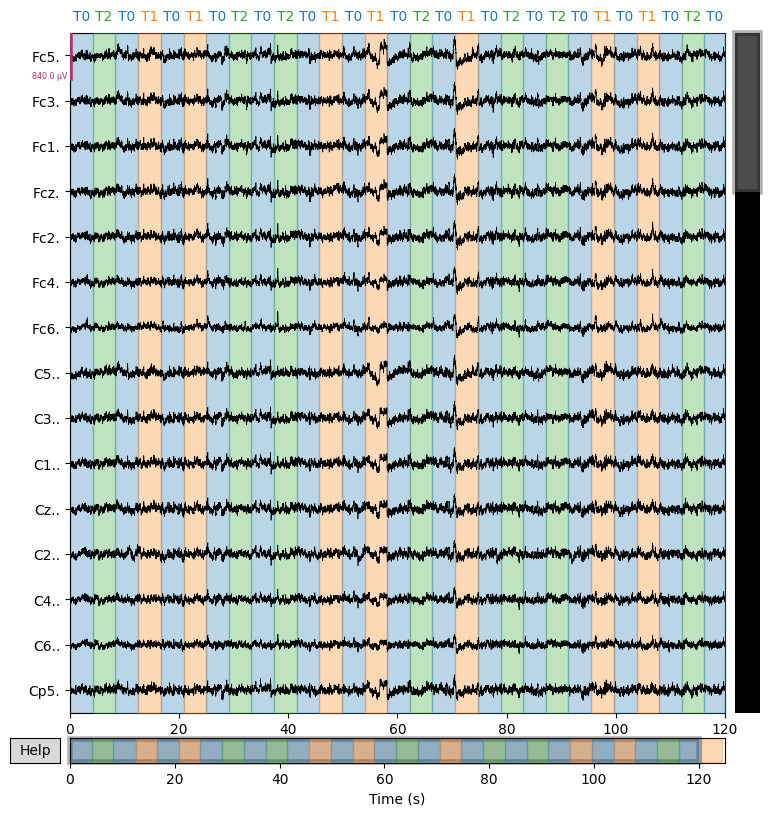

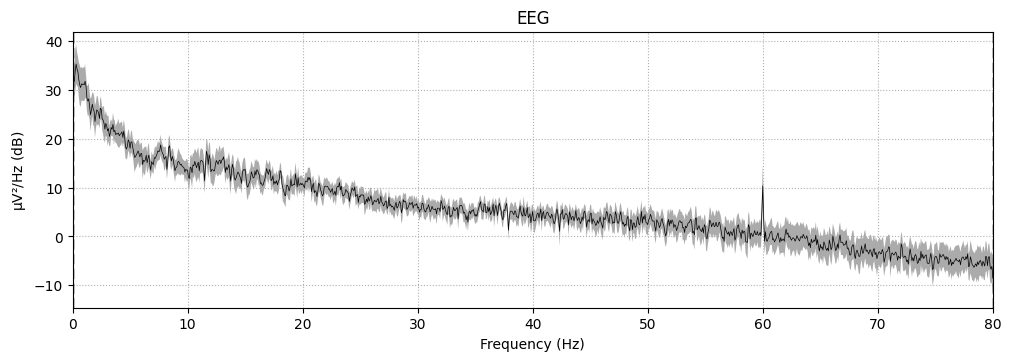

In [108]:
#Define the parameters
subject = 1  # use data from subject 1
runs = [6, 10, 14]  # use only hand and feet motor imagery runs

#Get data and locate in to given path
input_fname1 =  "/home/aurelien.stumpf/Code/physionet.org/files/eegmmidb/1.0.0/S001/S001R01.edf"
input_fname2 =  "/home/aurelien.stumpf/Code/physionet.org/files/eegmmidb/1.0.0/S001/S001R02.edf"
input_fname3 =  "/home/aurelien.stumpf/Code/datasets/eeg_data/physionet.org/files/eegmmidb/1.0.0/S001/S001R03.edf"
#Read raw data files where each file contains a run
raws = read_raw_edf(input_fname3, preload=True)
#Combine all loaded runs
#raw_obj = concatenate_raws(raws)
raw_obj = raws

raw_data = raw_obj.get_data()
print("Number of channels: ", str(len(raw_data)))
print("Number of samples: ", str(len(raw_data)))

#Plot epochs & PSD
raw_obj.plot(duration=120, n_channels=15, scalings=dict(eeg=420e-6))
raw_obj.plot_psd(average=True)

In [139]:
dict_channels = {'Fc5.' : 'FC5',
 'Fc3.' : 'FC3',
 'Fc1.' : 'FC1',
 'Fcz.' : 'FCz',
 'Fc2.' : 'FC2',
 'Fc4.' : 'FC4',
 'Fc6.' : 'FC6',
 'C5..' : 'C5',
 'C3..' : 'C3',
 'C1..' : 'C1',
 'Cz..' : 'Cz',
 'C2..' : 'C2',
 'C4..' : 'C4',
 'C6..' : 'C6',
 'Cp5.' : 'CP5',
 'Cp3.' : 'CP3',
 'Cp1.' : 'CP1',
 'Cpz.' : 'CPz',
 'Cp2.' : 'CP2',
 'Cp4.' : 'CP4',
 'Cp6.' : 'CP6',
 'Fp1.' : 'Fp1',
 'Fpz.' : 'Fpz',
 'Fp2.' : 'Fp2',
 'Af7.' : 'AF7',
 'Af3.' : 'AF3',
 'Afz.' : 'AFz',
 'Af4.' : 'AF4',
 'Af8.' : 'AF8',
 'F7..' : 'F7',
 'F5..' : 'F5',
 'F3..' : 'F3',
 'F1..' : 'F1',
 'Fz..' : 'Fz',
 'F2..' : 'F2',
 'F4..' : 'F4',
 'F6..' : 'F6',
 'F8..' : 'F8',
 'Ft7.' : 'FT7',
 'Ft8.' : 'FT8',
 'T7..' : 'T7',
 'T8..' : 'T8',
 'T9..' : 'T9',
 'T10.' : 'T10',
 'Tp7.' : 'TP7',
 'Tp8.' : 'TP8',
 'P7..' : 'P7',
 'P5..' : 'P5',
 'P3..' : 'P3',
 'P1..' : 'P1',
 'Pz..' : 'Pz',
 'P2..' : 'P2',
 'P4..' : 'P4',
 'P6..' : 'P6',
 'P8..' : 'P8',
 'Po7.' : 'PO7',
 'Po3.' : 'PO3',
 'Poz.' : 'POz',
 'Po4.' : 'PO4',
 'Po8.' : 'PO8',
 'O1..' : 'O1',
 'Oz..' : 'Oz',
 'O2..' : 'O2',
 'Iz..' : 'Iz'}


## Time Analysis

In [140]:
list_name_channels = ["Cp1.","Cp3.","Cp5.","C1..","C3..","C5..","C2..","Cp2.","Cz..","Fcz.","C4..","Cp4."]
ch_names = raw_obj.info['ch_names']
#list_idx_channels = [ch_names.index(name) for name in list_name_channels]
list_idx_channels = list(range(0, 64))

task_type = "imaginary_left/right"
folder_path = "/home/aurelien.stumpf/Code/datasets/eeg_data/physionet.org/files/eegmmidb/1.0.0/"

if task_type == "imaginary_feet/hand":
    num_runs = [5, 6, 9, 10, 13, 14]
    num_train_subjects = list(range(1, 22))
    num_test_subjects = list(range(64, 85))
elif task_type == "imaginary_left/right":
    num_runs = [4, 8, 12]
    num_train_subjects = list(range(1, 22))
    num_test_subjects = list(range(64, 85))
num_sessions = []
list_labels = [1,2]

torch_trainset = dataset.EEG_Time_Dataset_Multi_Subject(folder_path, num_train_subjects, num_sessions, num_runs, list_idx_channels, list_labels, data="physionet")
torch_testset = dataset.EEG_Time_Dataset_Multi_Subject(folder_path, num_test_subjects, num_sessions, num_runs,list_idx_channels, list_labels, data="physionet")
trainloader = torch.utils.data.DataLoader(torch_trainset, batch_size=16, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(torch_testset, batch_size=16, shuffle=True, num_workers=2)

In [141]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.CrossEntropyLoss()
model = EEGNet(chunk_size=480,
               num_electrodes=64,
               dropout=0,
               kernel_1=64,
               kernel_2=16,
               F1=8,
               F2=16,
               D=2,
               num_classes=2)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 50], gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.95)
training.train_model(model, trainloader, testloader, device, criterion, 200, optimizer, scheduler)

Epoch 0:   0%|          | 0/87 [00:00<?, ?batch/s]

Epoch 0: 100%|██████████| 87/87 [00:03<00:00, 23.73batch/s, accuracy=0.664, loss=0.0626] 

Epoch 0
lr:  0.095
-------------------------


Train set: Avg. loss: 0.0452, Balanced Accuracy: 0.5 (50%)
Test set: Avg. loss: 0.0455, Balanced Accuracy: 0.5 (50%)
-------------------------


Epoch 10: 100%|██████████| 87/87 [00:03<00:00, 25.26batch/s, accuracy=0.682, loss=0.0394] 

Epoch 10
lr:  0.05688000922764597
-------------------------


Train set: Avg. loss: 0.0394, Balanced Accuracy: 0.5 (50%)
Test set: Avg. loss: 0.0394, Balanced Accuracy: 0.5 (50%)
-------------------------


Epoch 20: 100%|██████████| 87/87 [00:03<00:00, 25.03batch/s, accuracy=0.719, loss=0.0363] 

Epoch 20
lr:  0.03405616262881148
-------------------------


Train set: Avg. loss: 0.0382, Balanced Accuracy: 0.5009826421737671 (50%)
Test set: Avg. loss: 0.0390, Balanced Accuracy: 0.4983370900154114 (50%)
-------------------------


Epoch 30: 100%|██████████| 87/87 [00:03<00:00, 25.33batch/s, accuracy=0.763, loss=0.0321] 

Epoch 30
lr:  0.020390682574579037
-------------------------


Train set: Avg. loss: 0.0289, Balanced Accuracy: 0.652456521987915 (65%)
Test set: Avg. loss: 0.0339, Balanced Accuracy: 0.611640214920044 (61%)
-------------------------


Epoch 40: 100%|██████████| 87/87 [00:03<00:00, 25.01batch/s, accuracy=0.794, loss=0.0288] 

Epoch 40
lr:  0.012208654873684792
-------------------------


Train set: Avg. loss: 0.0255, Balanced Accuracy: 0.8085411787033081 (81%)
Test set: Avg. loss: 0.0337, Balanced Accuracy: 0.7163265347480774 (72%)
-------------------------


Epoch 45:  64%|██████▍   | 56/87 [00:02<00:01, 23.12batch/s, accuracy=0.857, loss=0.0164] 


KeyboardInterrupt: 

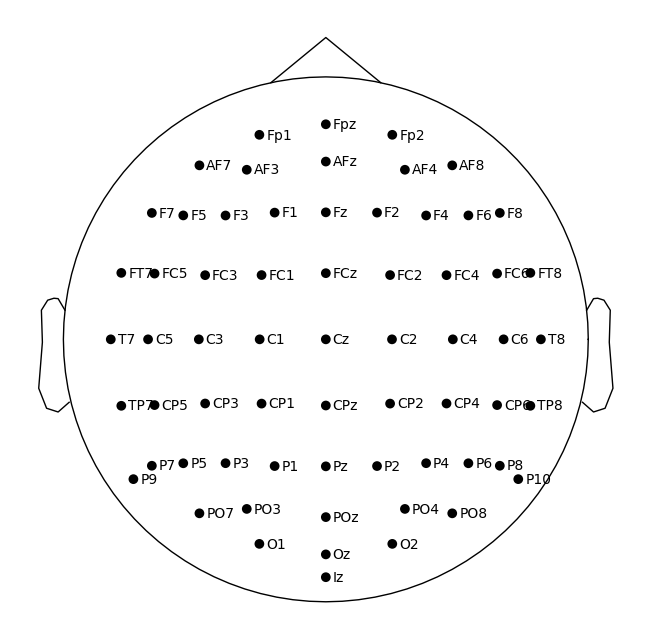

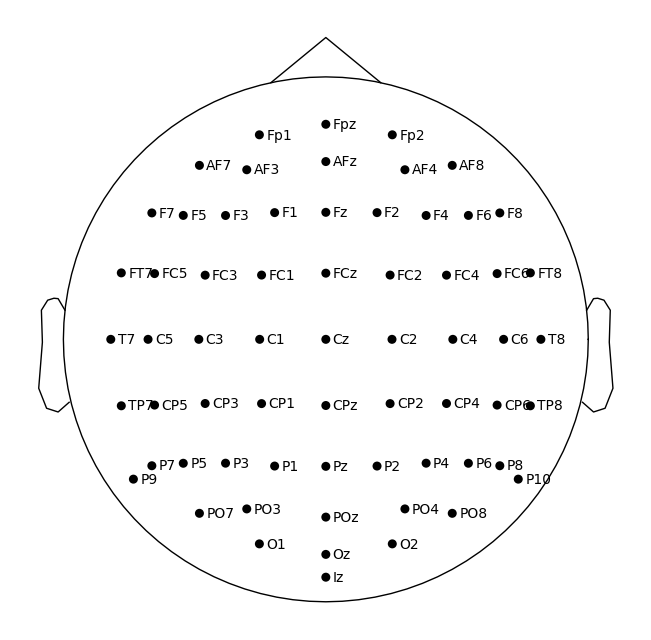

In [143]:
biosemi_montage = mne.channels.make_standard_montage('biosemi64')
biosemi_montage.plot()

In [148]:
def get_positions_from_channel_list(channel_list, montage):
    dict_positions = montage.get_positions()["ch_pos"]
    positions = []
    for channel in channel_list:
        positions.append(dict_positions[dict_channels[channel]])
    return positions

print(np.array(get_positions_from_channel_list(list_name_channels, biosemi_montage)))

[[-3.55974030e-02 -3.55974030e-02  8.05645691e-02]
 [-6.42558242e-02 -3.41654278e-02  6.10648229e-02]
 [-8.43493361e-02 -3.23786765e-02  2.93566145e-02]
 [-3.71194572e-02 -0.00000000e+00  8.74479611e-02]
 [-6.83372810e-02 -0.00000000e+00  6.59925452e-02]
 [-8.86901405e-02 -0.00000000e+00  3.40449552e-02]
 [ 3.71194572e-02  0.00000000e+00  8.74479611e-02]
 [ 3.55974030e-02 -3.55974030e-02  8.05645691e-02]
 [ 0.00000000e+00  0.00000000e+00  9.50000000e-02]
 [ 2.27291122e-18  3.71194572e-02  8.74479611e-02]
 [ 6.83372810e-02  0.00000000e+00  6.59925452e-02]
 [ 6.42558242e-02 -3.41654278e-02  6.10648229e-02]]


In [150]:
list_name_channels 

['Cp1.',
 'Cp3.',
 'Cp5.',
 'C1..',
 'C3..',
 'C5..',
 'C2..',
 'Cp2.',
 'Cz..',
 'Fcz.',
 'C4..',
 'Cp4.']

In [147]:
# display temporal filters of the first convolutional layer
spatial_filters = model.block1[2].weight.to('cpu').detach().squeeze(1).squeeze(2).numpy()
ch_positions = np.array(get_positions_from_channel_list(list_name_channels, biosemi_montage))
for i in range(8):
    mne.viz.plot_topomap(spatial_filters[i], ch_positions, cmap='coolwarm')

ValueError: The supplied electrode positions matrix contains 3 columns. Are you trying to specify XYZ coordinates? Perhaps the mne.channels.create_eeg_layout function is useful for you. Electrode positions should be specified as a 2D array with shape (n_channels, 2). Each row in this matrix contains the (x, y) position of an electrode.

In [ ]:
mat = model.block1[0].weight.to('cpu').detach().squeeze(1).squeeze(1).numpy()

## Graph Analysis

In [ ]:
list_name_channels = ["Cp1.","Cp3.","Cp5.","C1..","C3..","C5..","C2..","Cp2.","Cz..","Fcz.","C4..","Cp4."]
ch_names = raw_obj.info['ch_names']
#list_idx_channels = [ch_names.index(name) for name in list_name_channels]
list_idx_channels = list(range(0, 64))

task_type = "imaginary_left/right"
folder_path = "/home/aurelien.stumpf/Code/datasets/eeg_data/physionet.org/files/eegmmidb/1.0.0/"

if task_type == "imaginary_feet/hand":
    num_sessions = [5, 6, 9, 10, 13, 14]
    num_train_subjects = list(range(1, 22))
    num_test_subjects = list(range(64, 85))
elif task_type == "imaginary_left/right":
    num_sessions = [4, 8, 12]
    num_train_subjects = list(range(1, 22))
    num_test_subjects = list(range(64, 85))

torch_trainset = dataset.EEG_PSD_Dataset_Multi_Subject(folder_path, num_train_subjects, num_sessions, list_idx_channels, type_ = "torch", band=True)
torch_testset = dataset.EEG_PSD_Dataset_Multi_Subject(folder_path, num_test_subjects, num_sessions, list_idx_channels, type_ = "torch", band=True)
trainloader = torch.utils.data.DataLoader(torch_trainset, batch_size=16, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(torch_testset, batch_size=16, shuffle=True, num_workers=2)

In [ ]:
torch_trainset.features.shape

torch.Size([882, 64, 5])

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.CrossEntropyLoss()
model = DGCNN(in_channels=5, num_electrodes=64, hid_channels=128, num_layers=3, num_classes=2)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.95)
training.train_model(model, trainloader, testloader, device, criterion, 100, optimizer, scheduler)

Epoch 0:   0%|          | 0/56 [00:00<?, ?batch/s]

Epoch 0: 100%|██████████| 56/56 [00:00<00:00, 70.09batch/s, accuracy=0.499, loss=0.202]   


Epoch 0
lr:  0.095
-------------------------
Test set: Avg. loss: 38.9018, Accuracy: 441/882 (50%)
-------------------------


Epoch 10: 100%|██████████| 56/56 [00:00<00:00, 77.70batch/s, accuracy=0.523, loss=0.0445] 

Epoch 10
lr:  0.05688000922764597
-------------------------


Test set: Avg. loss: 38.8099, Accuracy: 441/882 (50%)
-------------------------


Epoch 16: 100%|██████████| 56/56 [00:00<00:00, 80.31batch/s, accuracy=0.493, loss=0.0441] 


KeyboardInterrupt: 